<a href="https://colab.research.google.com/github/NahidurRahaman/Face_Emotion_Recognition/blob/main/thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load FER2013 CSV
csv_path = '/content/drive/MyDrive/fer2013.csv'  # update path if needed
df = pd.read_csv(csv_path)

In [5]:
# Define emotion classes
emotion_labels = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
    4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}

# Custom dataset from CSV
class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pixels = list(map(int, self.df.iloc[idx]["pixels"].split()))
        img = np.asarray(pixels).reshape(48, 48).astype(np.uint8)
        img = Image.fromarray(img).convert("L")
        img = img.convert("RGB")  # convert to 3-channel RGB

        if self.transform:
            img = self.transform(img)

        label = int(self.df.iloc[idx]["emotion"])
        return img, label

In [6]:
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Resize((224, 224)),  # ESRGAN-like upscaling
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Split manually
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=42)

train_dataset = FER2013Dataset(train_df, transform=transform)
val_dataset = FER2013Dataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class ESRGANLikeUpsampler(nn.Module):
    def __init__(self, upscale_factor=4):
        super(ESRGANLikeUpsampler, self).__init__()
        self.upsample = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),      # Feature extraction
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=upscale_factor, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)       # Restore to RGB
        )

    def forward(self, x):
        return self.upsample(x)


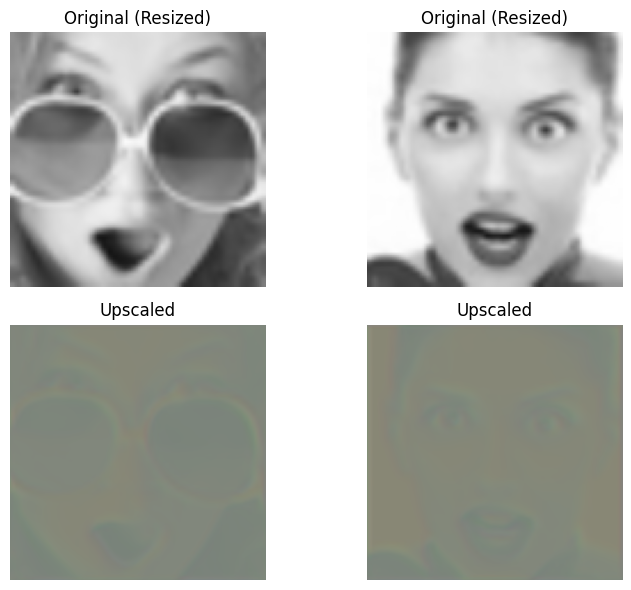

In [8]:
# Move upsampler to CPU for visualization to avoid OOM
upsampler = ESRGANLikeUpsampler().cpu()

sample_img, _ = next(iter(train_loader))
# Move sample image to CPU for visualization
sample_img = sample_img.cpu()

# Resize sample image to a smaller size for visualization to save memory
resize_transform = transforms.Resize((112, 112))
sample_img_resized = resize_transform(sample_img)


upscaled_img = upsampler(sample_img_resized[:2])  # Batch of 2 on resized images

# Visualize before vs after
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(8, 6)) # Adjusted for 2 images
for i in range(2):
    # Display the resized original image
    axs[0, i].imshow(sample_img_resized[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    axs[0, i].set_title("Original (Resized)")
    axs[1, i].imshow(upscaled_img[i].permute(1, 2, 0).detach().cpu().numpy() * 0.5 + 0.5)
    axs[1, i].set_title("Upscaled")
    axs[0, i].axis('off')
    axs[1, i].axis('off')
plt.tight_layout()
plt.show()

In [9]:
import torch.nn as nn
import timm


In [10]:
class EfficientNetV2S_FeatureExtractor(nn.Module):
    def __init__(self):
        super(EfficientNetV2S_FeatureExtractor, self).__init__()
        self.backbone = timm.create_model('efficientnetv2_s', pretrained=False, features_only=True)

    def forward(self, x):
        features = self.backbone(x)
        return features[-1]  # (B, 1280, 7, 7)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
efficientnet_model = EfficientNetV2S_FeatureExtractor().to(device)
efficientnet_model.eval()

# Use first batch from train_loader
for images, labels in train_loader:
    images = images.to(device)  # shape: (B, 3, 224, 224)
    labels = labels.to(device)

    with torch.no_grad():
        features = efficientnet_model(images)  # shape: (B, 1280, 7, 7)

    print("Input shape:", images.shape)
    print("EfficientNetV2-S Output shape:", features.shape)
    break

Input shape: torch.Size([16, 3, 224, 224])
EfficientNetV2-S Output shape: torch.Size([16, 256, 7, 7])


In [12]:
class ConvNeXtBlock(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super(ConvNeXtBlock, self).__init__()
        self.convnext = timm.create_model('convnext_tiny', pretrained=True, features_only=True)
        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.proj(x)  # Reduce 256 → 256 (no change)
        return x  # shape: B × 256 × 7 × 7

In [13]:
class SE_MBConvBlock(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super(SE_MBConvBlock, self).__init__()
        self.expand = nn.Conv2d(in_channels, in_channels * 6, kernel_size=1)
        self.depthwise = nn.Conv2d(in_channels * 6, in_channels * 6, kernel_size=3, padding=1, groups=in_channels * 6)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels * 6, in_channels // 4, 1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 4, in_channels * 6, 1),
            nn.Sigmoid()
        )
        self.project = nn.Conv2d(in_channels * 6, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.expand(x)
        x = self.depthwise(x)
        se_weight = self.se(x)
        x = x * se_weight
        x = self.project(x)
        return x  # shape: B × 256 × 7 × 7

In [14]:
adaptive_pool = nn.AdaptiveAvgPool2d((28, 28))


In [15]:
class MultiBranchFeatureExtractor(nn.Module):
    def __init__(self):
        super(MultiBranchFeatureExtractor, self).__init__()
        self.efficientnet = EfficientNetV2S_FeatureExtractor()
        self.convnext_block = ConvNeXtBlock()
        self.se_mbconv_block = SE_MBConvBlock()
        self.pool = nn.AdaptiveAvgPool2d((28, 28))  # Resize to 28×28

    def forward(self, x):
        x = self.efficientnet(x)  # Output: B × 1280 × 7 × 7

        convnext_feat = self.convnext_block(x)     # B × 256 × 7 × 7
        senet_feat    = self.se_mbconv_block(x)    # B × 256 × 7 × 7

        convnext_feat = self.pool(convnext_feat)   # B × 256 × 28 × 28
        senet_feat    = self.pool(senet_feat)      # B × 256 × 28 × 28

        return convnext_feat, senet_feat


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiBranchFeatureExtractor().to(device)
model.eval()

for images, labels in train_loader:
    images = images.to(device)

    with torch.no_grad():
        conv_feat, se_feat = model(images)

    print("ConvNeXt Output:", conv_feat.shape)  # [B, 256, 28, 28]
    print("SENet+MBConv Output:", se_feat.shape)  # [B, 256, 28, 28]
    break


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

ConvNeXt Output: torch.Size([16, 256, 28, 28])
SENet+MBConv Output: torch.Size([16, 256, 28, 28])


In [17]:
class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim=256, num_heads=4):
        super(CrossAttentionFusion, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, feat_q, feat_kv):
        # Input: B × 256 × 28 × 28
        B, C, H, W = feat_q.shape

        # Flatten to sequences: B × 784 × 256
        q = feat_q.view(B, C, -1).permute(0, 2, 1)   # Q: (B, 784, 256)
        kv = feat_kv.view(B, C, -1).permute(0, 2, 1) # K,V: (B, 784, 256)

        # Cross-attention
        attn_output, _ = self.attn(q, kv, kv)        # (B, 784, 256)
        attn_output = self.norm(attn_output + q)     # Residual + Norm

        # Reshape back to spatial map: (B, 256, 28, 28)
        fused = attn_output.permute(0, 2, 1).view(B, C, H, W)

        return fused  # Output: B × 256 × 28 × 28

In [18]:
class FullFeatureFusionBlock(nn.Module):
    def __init__(self):
        super(FullFeatureFusionBlock, self).__init__()
        self.backbone = MultiBranchFeatureExtractor()        # Gives conv_feat, se_feat
        self.cross_attn = CrossAttentionFusion(embed_dim=256, num_heads=4)

    def forward(self, x):
        conv_feat, se_feat = self.backbone(x)               # B × 256 × 28 × 28

        fused_feat = self.cross_attn(conv_feat, se_feat)    # B × 256 × 28 × 28

        return fused_feat  # ready for concatenation with other branches if needed

In [19]:
model = FullFeatureFusionBlock().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        fused_output = model(images)

    print("Fused Output Shape:", fused_output.shape)  # Expected: [B, 256, 28, 28]
    break

Fused Output Shape: torch.Size([16, 256, 28, 28])


In [20]:
class GlobalContextBranch(nn.Module):
    def __init__(self, in_channels=256, out_channels=64):
        super(GlobalContextBranch, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.ReLU(),
            nn.Upsample(size=(28, 28), mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        x = self.global_pool(x)   # [B, 256, 1, 1] after global pool, originally [B, 256, 7, 7]
        x = self.fc(x)            # [B, 64, 28, 28]
        return x

In [21]:
class LocalDetailBranch(nn.Module):
    def __init__(self, in_channels=256, out_channels=64):
        super(LocalDetailBranch, self).__init__()
        self.local_cnn = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.local_cnn(x)  # [B, 64, 28, 28]

In [22]:
class MultiBranchFullFusion(nn.Module):
    def __init__(self):
        super(MultiBranchFullFusion, self).__init__()
        self.feature_extractor = EfficientNetV2S_FeatureExtractor()

        self.convnext_block = ConvNeXtBlock()
        self.se_mbconv_block = SE_MBConvBlock()

        self.pool = nn.AdaptiveAvgPool2d((28, 28))
        self.cross_attn = CrossAttentionFusion(embed_dim=256)

        self.global_context = GlobalContextBranch()
        self.local_detail = LocalDetailBranch()

        # Add pooling to ensure consistent spatial dimensions before concatenation
        self.global_pool_out = nn.AdaptiveAvgPool2d((28, 28))
        self.local_pool_out = nn.AdaptiveAvgPool2d((28, 28))


    def forward(self, x):
        feat = self.feature_extractor(x)                # [B, 256, 7, 7]

        # ConvNeXt & SENet+MBConv
        conv_feat = self.pool(self.convnext_block(feat))  # [B, 256, 28, 28]
        se_feat   = self.pool(self.se_mbconv_block(feat)) # [B, 256, 28, 28]

        # Cross-attention fused output
        fused_attn = self.cross_attn(conv_feat, se_feat)  # [B, 256, 28, 28]

        # Extra branches
        global_feat = self.global_context(feat)           # Expected: [B, 64, 28, 28]
        local_feat  = self.local_detail(feat)             # Expected: [B, 64, 28, 28]

        # Ensure spatial dimensions are 28x28 before concatenation
        global_feat_pooled = self.global_pool_out(global_feat)
        local_feat_pooled = self.local_pool_out(local_feat)


        # Concatenate all
        final_feat = torch.cat([conv_feat, se_feat, fused_attn, global_feat_pooled, local_feat_pooled], dim=1)  # [B, 896, 28, 28]
        return final_feat

In [23]:
model = MultiBranchFullFusion().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        fusion_output = model(images)
    print("Final Fused Feature Shape:", fusion_output.shape)  # [B, 896, 28, 28]
    break


Final Fused Feature Shape: torch.Size([16, 896, 28, 28])


In [24]:
class MobileViTBlock(nn.Module):
    def __init__(self, in_channels, transformer_dim=128, patch_size=2, depth=2, heads=4):
        super(MobileViTBlock, self).__init__()
        self.patch_size = patch_size
        ph, pw = patch_size, patch_size

        self.local_rep = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )

        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        self.fold = nn.Fold(output_size=(28, 28), kernel_size=patch_size, stride=patch_size)

        self.conv_before_trans = nn.Conv2d(in_channels * ph * pw, transformer_dim, kernel_size=1)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=transformer_dim,
            nhead=heads,
            batch_first=True,
            dim_feedforward=transformer_dim * 2,
            dropout=0.1,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.conv_after_trans = nn.Conv2d(transformer_dim, in_channels * ph * pw, kernel_size=1)


        self.project = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )

    def forward(self, x):
        B, C, H, W = x.shape
        ph, pw = self.patch_size, self.patch_size

        identity = x # B × C × H × W

        x = self.local_rep(x) # B × C × H × W

        # Unfold, Conv, and flatten for Transformer
        x = self.unfold(x) # B × (C*ph*pw) × (H*W / (ph*pw))
        x = x.view(B, C, ph*pw, -1).permute(0, 3, 2, 1).contiguous().view(B, -1, C*ph*pw) # B × N × (C*ph*pw)
        x = self.conv_before_trans(x.permute(0, 2, 1).view(B, C*ph*pw, H//ph, W//pw)).view(B, self.conv_before_trans.out_channels, -1).permute(0, 2, 1) # B × N × transformer_dim


        # Transformer
        x = self.transformer(x) # B × N × transformer_dim

        # Project back and Fold
        x = self.conv_after_trans(x.permute(0, 2, 1).view(B, self.conv_after_trans.in_channels, H//ph, W//pw)) # B × (C*ph*pw) × H/ph × W/pw
        x = x.view(B, C*ph*pw, -1) # B × (C*ph*pw) × N
        x = self.fold(x) # B × C × H × W

        # Project and Residual Connection
        x = self.project(x) # B × C × H × W
        x = x + identity # Residual connection

        return x # B × in_channels × H × W

In [25]:
class FinalModelWithMobileViT(nn.Module):
    def __init__(self):
        super(FinalModelWithMobileViT, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)

    def forward(self, x):
        x = self.fusion(x)         # [B, 896, 28, 28]
        x = self.mobilevit(x)      # [B, 896, 28, 28]
        return x


In [26]:
model = FinalModelWithMobileViT().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        out = model(images)

    print("MobileViT Output Shape:", out.shape)  # [B, 896, 28, 28]
    break


MobileViT Output Shape: torch.Size([16, 896, 28, 28])


In [27]:
class FinalModelWithGAP(nn.Module):
    def __init__(self):
        super(FinalModelWithGAP, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)
        self.gap = nn.AdaptiveAvgPool2d(1)  # Global Avg Pool → [B, 896, 1, 1]

    def forward(self, x):
        x = self.fusion(x)            # [B, 896, 28, 28]
        x = self.mobilevit(x)         # [B, 896, 28, 28]
        x = self.gap(x)               # [B, 896, 1, 1]
        x = x.view(x.size(0), -1)     # Flatten → [B, 896]
        return x


In [28]:
model = FinalModelWithGAP().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        features = model(images)

    print("Final Feature Vector Shape:", features.shape)  # [B, 896]
    break


Final Feature Vector Shape: torch.Size([16, 896])


In [29]:
class EmotionClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(EmotionClassifier, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),                 # [B, 896, 1, 1] → [B, 896]
            nn.Dropout(dropout_rate),
            nn.Linear(896, 7)            # 7 emotion classes
        )

    def forward(self, x):
        x = self.fusion(x)            # [B, 896, 28, 28]
        x = self.mobilevit(x)         # [B, 896, 28, 28]
        x = self.gap(x)               # [B, 896, 1, 1]
        x = self.classifier(x)        # [B, 7]
        return x


In [30]:
model = EmotionClassifier().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        logits = model(images)

    print("Model Output Shape:", logits.shape)  # [B, 7]
    break


Model Output Shape: torch.Size([16, 7])


In [31]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [32]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=25):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = 100 * train_correct / total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / val_total
        val_acc = 100 * val_correct / val_total

        # Step scheduler
        scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Optional: Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Saved Best Model")

    print("Training Complete!")


In [ ]:
num_epochs = 30  # or as needed
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs)
